# Perkenalan

- Aldo Dwicahyo
- FTDS-004


# Import Pustaka

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import pathlib
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Hardware Usage

In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

print(tf.__version__)

Default GPU Device:/device:GPU:0Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


2.6.0


2021-12-03 15:33:20.835185: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-03 15:33:20.835749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-03 15:33:20.837916: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-03 15:33:20.837933: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Data Loading

## Dataset Folder Path

In [4]:
dataset_folder = '/Users/siaaldo/Documents/Hacktiv8/P2M2/milestone2data/'
nonMask_folder = '/Users/siaaldo/Documents/Hacktiv8/P2M2/milestone2data/No Mask/'
mask_folder = '/Users/siaaldo/Documents/Hacktiv8/P2M2/milestone2data/Mask/'

dataset_data = pathlib.Path(dataset_folder)
mask_data = pathlib.Path(mask_folder)
nonMask_data = pathlib.Path(nonMask_folder)

## Creating Dataset

In [5]:
mask_images = list(mask_data.glob('*/*')) #select all format variances
nonMask_images = list(nonMask_data.glob('*/*')) #select all format variances

print(f'Total Data Gambar {len(mask_images)+len(nonMask_images)} gambar')
print(f'Jumlah data gambar ber masker {len(mask_images)} gambar')
print(f'Jumlah data gambar tidak ber masker {len(nonMask_images)} gambar')

Total Data Gambar 339 gambar
Jumlah data gambar ber masker 208 gambar
Jumlah data gambar tidak ber masker 131 gambar


## Classes Variable

In [6]:
classes = {
    'mask' : mask_images,
    'non_mask' : nonMask_images
}

# Data Preprocessing

## Image Size Converter

In [7]:
batch_size = 32

#image pixel for uniform size each image
img_height = 200
img_width = 300

## Train Validation Data Split

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_folder,
  validation_split=0.05,
  labels='inferred',
  subset="training",
  seed=25,
  image_size=(img_height, img_width),
  label_mode='binary',
  batch_size=batch_size)

Found 339 files belonging to 2 classes.
Using 323 files for training.


2021-12-03 15:33:20.960920: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-03 15:33:20.960965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_folder,
  validation_split=0.25,
  subset="validation",
  seed=25,
  image_size=(img_height, img_width),
  label_mode='binary',
  batch_size=batch_size
)

Found 339 files belonging to 2 classes.
Using 84 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Mask', 'No Mask']


## Performance Enhance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Features & Label Shape

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2021-12-03 15:33:21.107096: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-03 15:33:21.108485: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(32, 200, 300, 3)
(32, 1)


# Model Definition

membuat model default menggunakan `Sequential API` dengan `2 Convolution Layers`

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [14]:
model = Sequential([
    layers.InputLayer(input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.Rescaling(1./255.),
    # data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 200, 300, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 75, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 120000)            0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Model Training

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10)

Epoch 1/10


2021-12-03 15:33:23.567000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 3.2955 - accuracy: 0.5418

2021-12-03 15:33:26.173604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 4s 294ms/step - loss: 3.2955 - accuracy: 0.5418 - val_loss: 0.9982 - val_accuracy: 0.5952
Epoch 2/10
11/11 [==============================] - 2s 228ms/step - loss: 0.6828 - accuracy: 0.6873 - val_loss: 0.5836 - val_accuracy: 0.7619
Epoch 3/10
11/11 [==============================] - 2s 223ms/step - loss: 0.5823 - accuracy: 0.7183 - val_loss: 0.4989 - val_accuracy: 0.8333
Epoch 4/10
11/11 [==============================] - 2s 225ms/step - loss: 0.4006 - accuracy: 0.8297 - val_loss: 0.3415 - val_accuracy: 0.8690
Epoch 5/10
11/11 [==============================] - 2s 228ms/step - loss: 0.2840 - accuracy: 0.9040 - val_loss: 0.2843 - val_accuracy: 0.8571
Epoch 6/10
11/11 [==============================] - 2s 227ms/step - loss: 0.2240 - accuracy: 0.9257 - val_loss: 0.2767 - val_accuracy: 0.8929
Epoch 7/10
11/11 [==============================] - 2s 221ms/step - loss: 0.1606 - accuracy: 0.9443 - val_loss: 0.2197 - val_accuracy: 0.9048
Epoch 8/10
11/11 

# Model Evaluation

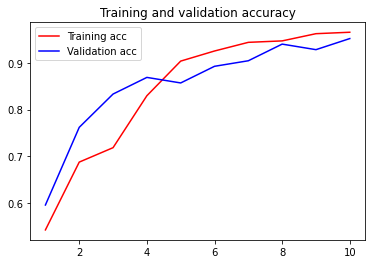

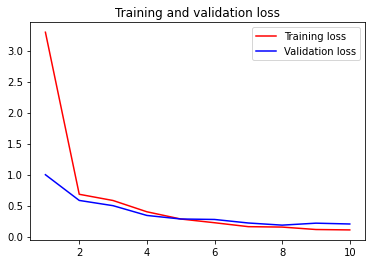

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

Dari hasil Training default model dengan 10 epochs. Jika dilihat sekilas dari nilai akurasi training, model ini bisa dikatakan sempurna. Namun jika dibandingkan dengan akurasi validasinya, nilai ini bisa termasuk kedalam `Overfit`. Maka untuk membuat model menjadi lebih baik, akan dilakukan model improvement

# Model Improvement

Untuk menaikan nilai akurasi dan menurunkan kemungkinan `Overfitting` saya akan malakukan menggunakan Dropout pada akhir Convolution Layer, callback Early Stopping, dan menambahkan beberapa Convolution Layers

In [19]:
model = Sequential([
    layers.InputLayer(input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.Rescaling(1./255.),
    # data_augmentation,
    layers.Conv2D(16, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 200, 300, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 300, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 150, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 150, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 75, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 120000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [22]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                               restore_best_weights=True)
)

Epoch 1/100


2021-12-03 15:33:49.644451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 2.9599 - accuracy: 0.6099

2021-12-03 15:33:51.834936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 236ms/step - loss: 2.9599 - accuracy: 0.6099 - val_loss: 1.1556 - val_accuracy: 0.6786
Epoch 2/100
11/11 [==============================] - 2s 221ms/step - loss: 1.0632 - accuracy: 0.6780 - val_loss: 0.4125 - val_accuracy: 0.8214
Epoch 3/100
11/11 [==============================] - 2s 213ms/step - loss: 0.5070 - accuracy: 0.7368 - val_loss: 0.3766 - val_accuracy: 0.8810
Epoch 4/100
11/11 [==============================] - 2s 229ms/step - loss: 0.3870 - accuracy: 0.8576 - val_loss: 0.3088 - val_accuracy: 0.8810
Epoch 5/100
11/11 [==============================] - 2s 213ms/step - loss: 0.2767 - accuracy: 0.9164 - val_loss: 0.2346 - val_accuracy: 0.9286
Epoch 6/100
11/11 [==============================] - 2s 214ms/step - loss: 0.2159 - accuracy: 0.9195 - val_loss: 0.2027 - val_accuracy: 0.9405
Epoch 7/100
11/11 [==============================] - 2s 230ms/step - loss: 0.1593 - accuracy: 0.9443 - val_loss: 0.1982 - val_accuracy: 0.9286
Epoch 8/100

# Findal Model Evaluation

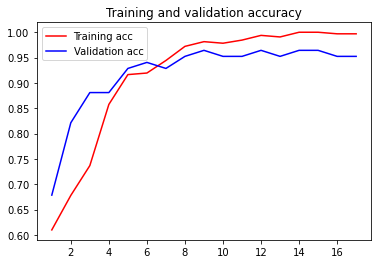

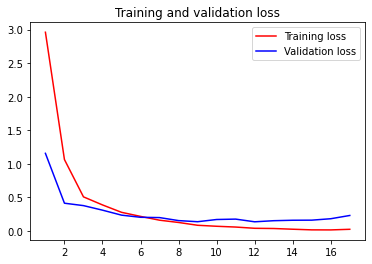

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()

Dapat dilihat bahwa model mengalami peningkatan performa baik dari loss dan akurasinya yang cenderung stabil dilihat dari grafik diatas.

# Model Inference

model inference saya mangambil beberapa data dari internet secara random

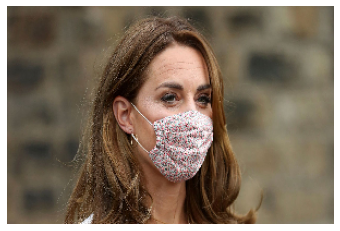

Result     :  [[0]]
Class Name :  Mask



2021-12-03 15:34:31.032274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


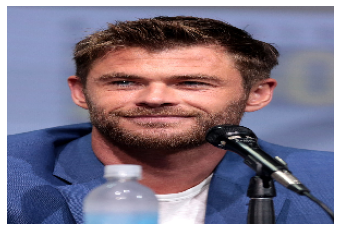

Result     :  [[1]]
Class Name :  No Mask



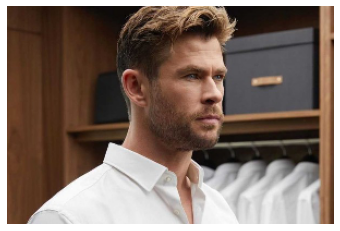

Result     :  [[1]]
Class Name :  No Mask



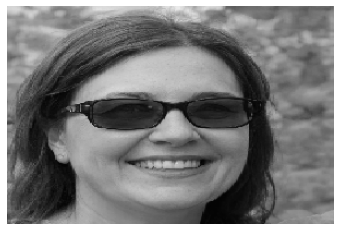

Result     :  [[0]]
Class Name :  Mask



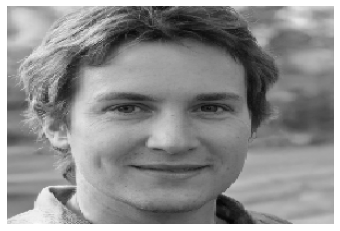

Result     :  [[1]]
Class Name :  No Mask



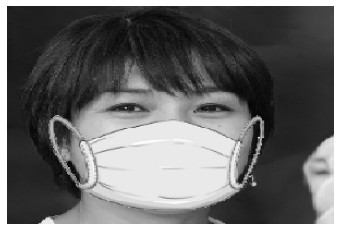

Result     :  [[0]]
Class Name :  Mask



In [24]:
img_paths = ['/Users/siaaldo/Documents/Hacktiv8/P2M2/5f60e6cb24000005101ed4f3.jpeg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/1200px-Chris_Hemsworth_by_Gage_Skidmore.jpeg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/fromandroid-33784252b42696bcb68ab7f56fa5600f_600x400.jpeg',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/seed0597.png',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/seed1821.png',
             '/Users/siaaldo/Documents/Hacktiv8/P2M2/with-mask-default-mask-seed0724.png'
]


for filename in img_paths:
  img = image.load_img(filename, target_size=(img_height, img_width))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)

  prediction = (model.predict(img_batch) > 0.5).astype("int32")
  result_max_proba = prediction[0][0]
  result_class = class_names[result_max_proba]

  print('Result     : ', prediction)
  print('Class Name : ', result_class)
  print('')

Dari Model Inference diatas, ternyata dengan akurasi tinggi pun model masih bisa mendeteksi kesalahan gambar dari gambar random yang diberikan

# Model Saving

In [25]:
model.save("cnn_model.RB")

2021-12-03 15:34:31.662892: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: cnn_model.RB/assets


# Kesimpulan

Dari dataset yang ada, tenyata jika menggunakan model sederhana terjadi overfit walaupun menghasilkan nilai akurasi yang sangat tinggi. Namun setelah dilakukan Model Improvement dengan menjadikan model menjadi sedikit lebih kompleks dengan mengganti beberapa hyper parameter sebagai berikut :
> - Menggunakan Dropout
> - Menggunakan Early Stopping

model menjadi lebih baik dari aspek fiting model dilihat dari loss dan akurasi training dan validation yang cenderung beriringan membaik satu dengan yang lain

In [27]:
model.save('mask_model.h5')